In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import math
import random
import pickle

In [5]:
## Loading pickle files
df_calendar = pickle.load(open("calendar.pkl","rb"))
df_sale = pickle.load(open("sales.pkl","rb"))
df_price = pickle.load(open("sell_prices.pkl","rb"))

In [7]:
from fbprophet import Prophet
columns = df_sale.columns
date_columns = columns[columns.str.contains("d_")]
dates_s = [pd.to_datetime(df_calendar.loc[df_calendar['d'] == str_date,'date'].values[0]) for str_date in date_columns]

tmp = df_sale[date_columns].sum()
ignore_date = df_calendar[df_calendar['d'].isin(tmp[tmp < 10000].index.values)]['date'].values

df_ev_1 = pd.DataFrame({'holiday': 'Event 1', 'ds': df_calendar[~df_calendar['event_name_1'].isna()]['date']})
df_ev_2 = pd.DataFrame({'holiday': 'Event 2', 'ds': df_calendar[~df_calendar['event_name_2'].isna()]['date']})
df_ev_3 = pd.DataFrame({'holiday': 'snap_CA', 'ds': df_calendar[df_calendar['snap_CA'] == 1]['date']})
df_ev_4 = pd.DataFrame({'holiday': 'snap_TX', 'ds': df_calendar[df_calendar['snap_TX'] == 1]['date']})
df_ev_5 = pd.DataFrame({'holiday': 'snap_WI', 'ds': df_calendar[df_calendar['snap_WI'] == 1]['date']})
holidays = pd.concat((df_ev_1, df_ev_2, df_ev_3, df_ev_4, df_ev_5))

def CreateTimeSeries(id):
    item_series =  df_sale[df_sale['id'] == id]
    dates = pd.DataFrame({'ds': dates_s}, index=range(len(dates_s)))
    dates['y'] = item_series[date_columns].values.transpose()
    # Remove chirstmas date
    #dates = dates[~dates['ds'].isin(ignore_date)]
    # Remove zero day
    #dates = dates[dates['y'] > 0]        
    return dates

In [8]:
#forecast with prophet without holiday
ids1 = np.array(['FOODS_3_090_WI_3_validation','FOODS_3_785_CA_1_validation'])
#forecast with prophet with holiday
ids2 = np.array(['FOODS_3_362_CA_3_validation'])
#forecast with prophet top down
ids3 = df_sale['id'].values
#forecast with ma
ids4 = np.array(['FOODS_3_090_CA_3_validation'])

#other predict
ids = np.concatenate((ids1, ids2, ids4), axis=0)
#Default prophet top down
ids3 = ids3[~np.isin(ids3,ids)]


print(f'Prophet without: {ids1.shape[0]}, Prophet bu: {ids2.shape[0]}, Prophet td: {ids3.shape[0]}, MA : {ids4.shape[0]}')
print(f'Total ids: {ids1.shape[0] + ids2.shape[0] + ids3.shape[0] + ids4.shape[0]} , Total sample: {df_sale.shape[0]}')

Prophet without: 2, Prophet bu: 1, Prophet td: 30486, MA : 1
Total ids: 30490 , Total sample: 30490


In [9]:
# Check duplicate
np.setdiff1d(ids1,np.setdiff1d(ids1,ids2))

array([], dtype='<U27')

In [10]:
%%time

# Without holiday

def run_prophet(id):
    timeserie = CreateTimeSeries(id)
    model = Prophet(uncertainty_samples=False)
    model.fit(timeserie)
    forecast = model.make_future_dataframe(periods=28, include_history=False)
    forecast = model.predict(forecast)
    return np.append(np.array([id]),forecast['yhat'].values.transpose())


from multiprocessing import Pool, cpu_count
print(f'Parallelism on {cpu_count()} CPU')
with Pool(cpu_count()) as p:
    predictions1  = list(p.map(run_prophet, ids1))

Parallelism on 4 CPU


INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 48 ms, sys: 101 ms, total: 149 ms
Wall time: 8.58 s


In [11]:
%%time

# With holiday

def run_prophet2(id):
    timeserie = CreateTimeSeries(id)
    model = Prophet(holidays = holidays, uncertainty_samples = False, n_changepoints = 50, changepoint_range = 0.8, changepoint_prior_scale = 0.7)
    # changepoint_prior_scale default is 0.5. Increasing it will make the trend more flexible    
    model.fit(timeserie)
    forecast = model.make_future_dataframe(periods=28, include_history=False)
    forecast = model.predict(forecast)
    return np.append(np.array([id]),forecast['yhat'].values.transpose())


from multiprocessing import Pool, cpu_count
print(f'Parallelism on {cpu_count()} CPU')
with Pool(cpu_count()) as p:
    predictions2  = list(p.map(run_prophet2, ids2))

Parallelism on 4 CPU


INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 75.7 ms, sys: 90.6 ms, total: 166 ms
Wall time: 39.7 s


In [12]:
%%time

df_sale_group_item = df_sale[np.hstack([['dept_id','store_id'],date_columns])].groupby(['dept_id','store_id']).sum()
df_sale_group_item = df_sale_group_item.reset_index()

def CreateTimeSeries3(dept_id, store_id):
    item_series =  df_sale_group_item[(df_sale_group_item.dept_id == dept_id) & (df_sale_group_item.store_id == store_id)]
    dates = pd.DataFrame({'ds': dates_s}, index=range(len(dates_s)))
    dates['y'] = item_series[date_columns].values[0].transpose()     
    return dates

def run_prophet3(dept_id, store_id):
    timeserie = CreateTimeSeries3(dept_id, store_id)
    # Tunned by one id
    #model = Prophet(holidays = holidays, uncertainty_samples = False, n_changepoints = 50, changepoint_range = 0.8, changepoint_prior_scale = 0.7)
    # Tunned by level 9    
    model = Prophet(holidays = holidays, uncertainty_samples = False, n_changepoints = 50, changepoint_range = 0.8, changepoint_prior_scale = 0.7, seasonality_mode = 'multiplicative')
    model.fit(timeserie)
    forecast = model.make_future_dataframe(periods=28, include_history=False)
    forecast = model.predict(forecast)
    return np.append(np.array([dept_id,store_id]),forecast['yhat'].values.transpose())

# create list param
ids = []
for i in range(0,df_sale_group_item.shape[0]):
    ids = ids + [(df_sale_group_item[i:i+1]['dept_id'].values[0],df_sale_group_item[i:i+1]['store_id'].values[0])]

print(f'Parallelism on {cpu_count()} CPU')
with Pool(cpu_count()) as p:
    predictions3  = list(p.starmap(run_prophet3, ids))

Parallelism on 4 CPU


INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality

CPU times: user 3.55 s, sys: 955 ms, total: 4.5 s
Wall time: 6min 52s


In [13]:
df_prophet_forecast_3 = pd.DataFrame()
for k in range(0, len(predictions3)):
    dept_id = predictions3[k][0]
    store_id = predictions3[k][1]

    df_item = df_sale.loc[(df_sale.dept_id == dept_id) & (df_sale.store_id == store_id)][['id']]
    df_item['val'] = df_sale[(df_sale.dept_id == dept_id) & (df_sale.store_id == store_id)].iloc[:, np.r_[0,-28:0]].sum(axis = 1)
    for i in range(1,29):
        df_item[f'F{i}'] = (df_item['val'] * float(predictions3[k][i+1]) / df_item['val'].sum())
    df_prophet_forecast_3 = pd.concat([df_prophet_forecast_3, df_item])

df_prophet_forecast_3 = df_prophet_forecast_3.drop('val',axis=1)

In [14]:
df_sample = pd.read_csv('sample_submission.csv.zip')

In [15]:
# Forecast with MA
df_last_sale = df_sale.iloc[:, np.r_[0,-28:0]].melt('id', var_name='d', value_name='sale')
df_last_sale = df_last_sale.merge(df_calendar.loc[:,['d','date','wday']])
last_date = int(df_last_sale.d.max()[2:])
df_last_sale = df_last_sale.groupby(['id','wday'])['sale'].mean()


df_ma_forecast = df_sample.copy()
df_ma_forecast.columns = ['id'] + ['d_' + str(last_date + x) for x in range(1, 29)]
df_ma_forecast = df_ma_forecast.loc[df_ma_forecast.id.str.contains('validation')]

df_ma_forecast = df_ma_forecast.melt('id', var_name='d', value_name='sale')
df_ma_forecast = df_ma_forecast.drop('sale',axis = 1)
df_ma_forecast = df_ma_forecast.merge(df_calendar.loc[:,['d','date','wday']])
df_ma_forecast = df_ma_forecast.join(df_last_sale, on=['id', 'wday'])

df_ma_forecast = df_ma_forecast.pivot(index='id', columns='d', values='sale')
df_ma_forecast = df_ma_forecast.reset_index()

In [16]:
if len(ids4) > 0:
    df_ma_forecast = df_ma_forecast[df_ma_forecast.id.isin(ids4)]
    df_ma_forecast.columns = df_sample.columns
else:
    df_ma_forecast = pd.DataFrame()

if len(ids1) > 0:
    df_prophet_forecast_1 = pd.DataFrame(predictions1)
    df_prophet_forecast_1.columns = df_sample.columns
else:
    df_prophet_forecast_1 = pd.DataFrame()

if len(ids2) > 0:
    df_prophet_forecast_2 = pd.DataFrame(predictions2)
    df_prophet_forecast_2.columns = df_sample.columns
else:
    df_prophet_forecast_2 = pd.DataFrame()


df_prophet_forecast_3.columns = df_sample.columns
df_prophet_forecast_3 = df_prophet_forecast_3[df_prophet_forecast_3.id.isin(ids3)]


df_sub_val = pd.concat([df_ma_forecast,df_prophet_forecast_1, df_prophet_forecast_2,df_prophet_forecast_3], sort=False)

df_sub_eval = df_sub_val.copy()
df_sub_eval['id'] = df_sub_eval['id'].str.replace("validation", "evaluation")

df_sub = pd.concat([df_sub_val,df_sub_eval], sort=False)
df_sub = df_sub.sort_values('id')

# Fix negative forecast
num = df_sub._get_numeric_data()
num[num < 0] = 0

df_sub.to_csv('submission.csv', index=False)

print(f'Submission shape: {df_sub.shape}')
print(f'Prophet without holiday: {df_prophet_forecast_1.shape[0]}, Prophet bu: {df_prophet_forecast_2.shape[0]}, Prophet td: {df_prophet_forecast_3.shape[0]}, MA: {df_ma_forecast.shape[0]}')

Submission shape: (60980, 29)
Prophet without holiday: 2, Prophet bu: 1, Prophet td: 30486, MA: 1


In [17]:
# Random Check
import matplotlib.pyplot as plt
import random
%matplotlib inline

def plotForecast(item_id):
    his_step = 100
    plt.plot(dates_s[-his_step:] + [dates_s[-1:][0] + pd.DateOffset(days=x) for x in range(28)], np.append(df_sale[df_sale['id'] == item_id][date_columns].values[0][-his_step:],df_sub[df_sub['id'] == item_id].values[0][1:]))
    plt.plot(dates_s[-his_step:], df_sale[df_sale['id'] == item_id][date_columns].values[0][-his_step:])
    if item_id in ids1:
        plt.title(f' Prophet without holiday forecast: {item_id}')    
    elif item_id in ids2:
        plt.title(f' Prophet bu forecast: {item_id}')
    elif item_id in ids3:
        plt.title(f' Prophet td forecast: {item_id}')
    else:
        plt.title(f' MA forecast: {item_id}')
    plt.gcf().autofmt_xdate()

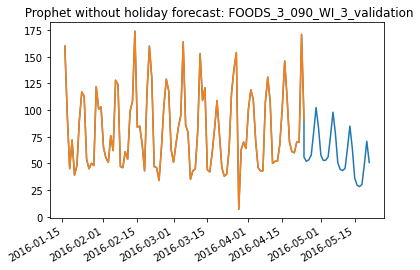

In [18]:
if len(ids1)>0:
    item_id = ids1[random.randint(0, len(ids1) - 1)]
    plotForecast(item_id)

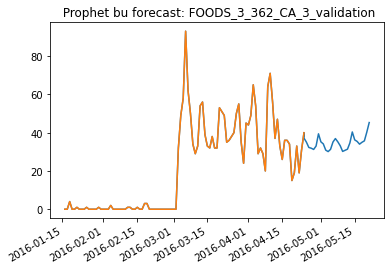

In [19]:
if len(ids2)>0:
    item_id = ids2[random.randint(0, len(ids2) - 1)]
    plotForecast(item_id)

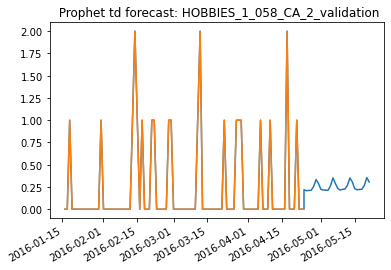

In [20]:
if len(ids3)>0:
    item_id = ids3[random.randint(0, len(ids3) - 1)]
    plotForecast(item_id)

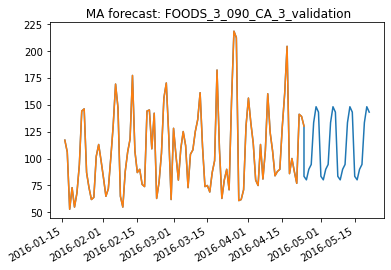

In [21]:
if len(ids4)>0:
    item_id = ids4[random.randint(0, len(ids4) - 1)]
    plotForecast(item_id)